## Bitcoin trend prediction using realtime market data

This project uses the SARIMAX modelisation of time series, applied to realtime Bitcoin data.  

1. Retrieve realtime BTC Price from ccxt API
2. Perform a grid search to find the best performing SARIMAX model
3. Using this last model, predict for the next 10 days the BTC prices. 



In [1]:
import ccxt
import time
from datetime import datetime, timezone
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from pylab import rcParams
import itertools

## 1. Data collection

The BTC price is not unique. It depends on the exchange picked. Here, for the sake of simplicity, I chose on of the largest BTC exchange for price history, Kraken. 

Furthermore, BTC price is not linear. Like most financial data, its value is shared in the form of OHLCV "candles". That is, in a timeframe (here : one hour), what has been the Opening price, the Highest trade, the Lowest trade, the Closing price, and the Volume of trade. 

I chose to perform the prediction solely on closing prices. 

In [2]:
def get_latest_candles(wordy=True):
    """Returns the hourly candles data from the last 720 hours"""
    # To retrieve data, use ccxt's connexion to Kraken's API. 
    exchange = ccxt.kraken({'enableRateLimit': True})
    # Fetch hourly OHLCV (Open High Low Close Volume) data from last 720 hours (30 days)
    if wordy: 
        print('Downloading...')
    price_history = exchange.fetch_ohlcv ('BTC/USD', '1h')
    time.sleep(exchange.rateLimit / 1000)
    if wordy: 
        print('Downloaded. Processing...')
    price_history = np.array(price_history)
    # Sort by the timestamp (first column) in case of errors
    price_history = price_history[price_history[:,0].argsort()]
    if wordy: 
        print('Processed.')
    return price_history[:,1:]

price_history = get_latest_candles()

Downloading...
Downloaded. Processing...
Processed.


To visualize the data better, let's decompose it seasonaly. The price time series corresponds to about a month, so a season period of one week is chosen. 

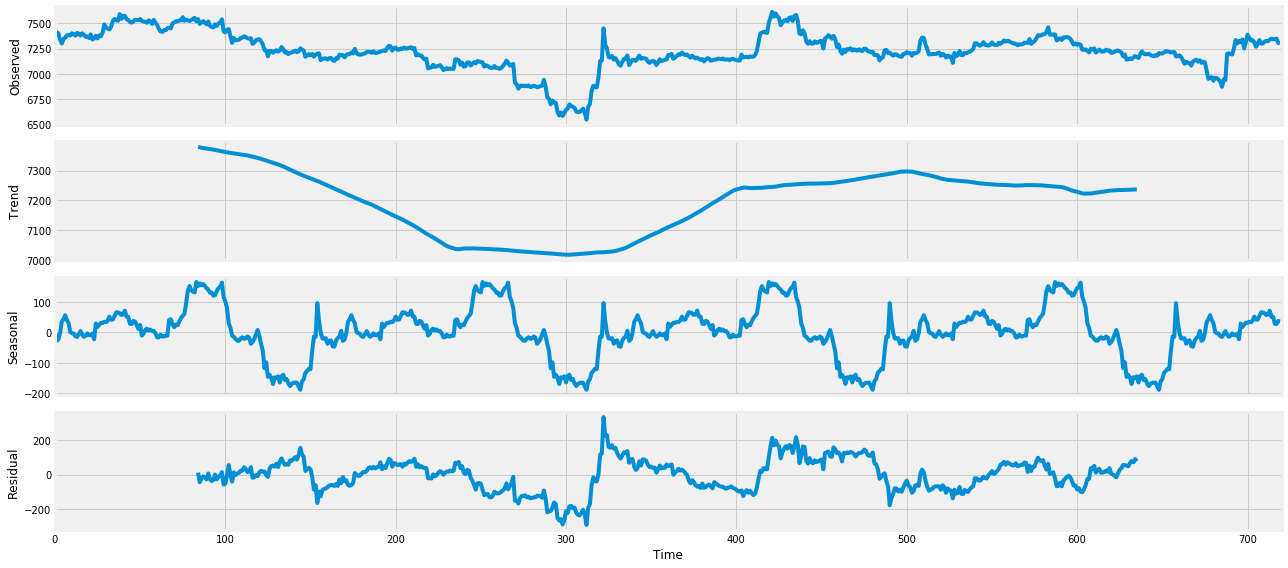

In [34]:
# Decomposition
rcParams['figure.figsize'] = 18, 8
# Freq = 168 corresponds to a week. 
decomposition = sm.tsa.seasonal_decompose(price_history[:,3], model='additive', freq=168)
fig = decomposition.plot()

plt.show()


## 2. Grid search of the best model

SARIMAX is a specific kind of modelisation that tries to predict the next value in a time series using its previous values, the errors of previous predictions, and exogenous variables. 

Here, I use the volume as an exogenous variable. 

Since there are many ways of chosing parameters for SARIMAX, a gridsearch is used to find the best one. Some of those models might not converge. This is ok. 

In [38]:
def grid_search_best_model(y, X, wordy=True):
    """Perform a grid search on the parameters of the ARIMAX model,
    then returns the best fitting model."""
    p = range(0, 3)
    pdq = list(itertools.product(p, p, p))
    trends = ['c', 't', 'ct']

    smallest_aic = 10E99
    best_res = None
    best_param = None

    for param in pdq:
        for param_trend in trends:
            model_param = param #+ (param_seasonal,)
            model = sm.tsa.statespace.SARIMAX(y, X, trend=param_trend, order=model_param)
            res = model.fit(disp=False)
            # AIC is the Akaike information criterion. It is a measure of information lost.
            # The smaller the AIC, the less information is lost, and the better the model. 
            if res.aic < smallest_aic:
                if wordy: print('PARAMETERS :', model_param, '; AIC :', res.aic)
                smallest_aic = res.aic
                best_res = res
                best_param = model_param
    
    return best_res, best_param

y = price_history[:,3]
X = price_history[:,4]

res, param = grid_search_best_model(y, X)
print(res.params)
print(res.summary())




PARAMETERS : (0, 0, 0) ; AIC : 9569.128396466122


/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


PARAMETERS : (0, 0, 0) ; AIC : 9549.939741561087


/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


PARAMETERS : (0, 0, 1) ; AIC : 9378.405538895146


/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


PARAMETERS : (0, 1, 0) ; AIC : 7167.8400378767055
PARAMETERS : (0, 1, 1) ; AIC : 7167.513645290041
PARAMETERS : (0, 1, 1) ; AIC : 7167.511943522426
PARAMETERS : (0, 1, 2) ; AIC : 7166.918974099729


/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


PARAMETERS : (0, 2, 1) ; AIC : 7166.448285625342
PARAMETERS : (0, 2, 2) ; AIC : 7166.233538384007


/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

PARAMETERS : (1, 2, 1) ; AIC : 7165.92967006812


/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: Co

PARAMETERS : (2, 1, 2) ; AIC : 7156.710958868717


/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/haxxor/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[-1.15354610e+00 -4.61102608e-03 -1.73744503e+00 -9.22068472e-01
  1.67543459e+00  8.73733306e-01  1.20607543e+03]
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3571.355
Date:                Sat, 04 Jan 2020   AIC                           7156.711
Time:                        12:19:10   BIC                           7188.756
Sample:                             0   HQIC                          7169.083
                                - 720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.1535      5.813     -0.198      0.843     -12.546      10.239
x1            -0

## 3. Forecasting

Using the best model found before, let's forecast the most likely BTC price evolution for the next 10 days. 

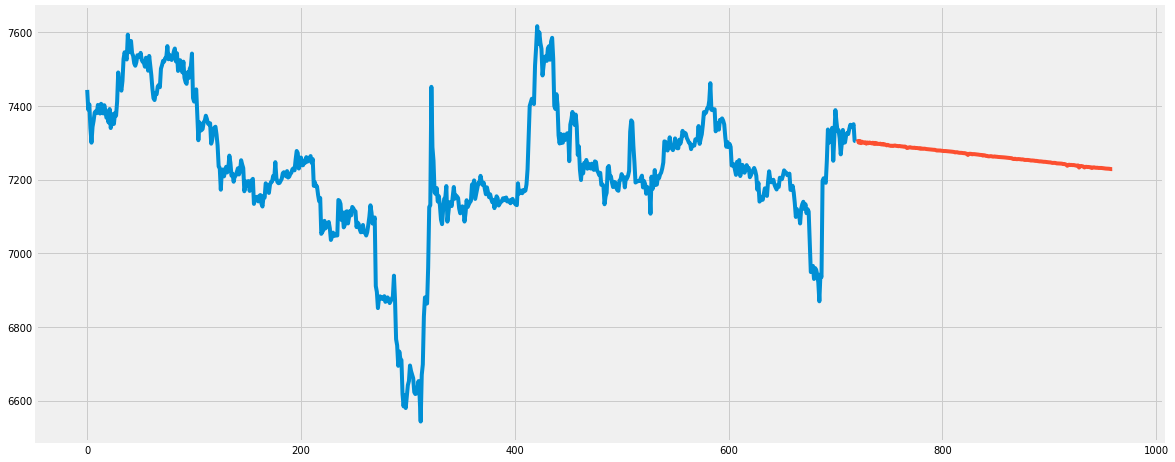

In [41]:
# Forecasting

n_predict = 240
# We reuse the previous 10 days of volume variance for prediction. 
forecast = res.forecast(n_predict, exog=price_history[480:,4].reshape(-1,1))
price_history[:,2]
u = np.array(range(price_history.shape[0]))
v = np.array(range(price_history.shape[0], price_history.shape[0]+n_predict))

plt.plot(u, price_history[:,3])
plt.plot(v, forecast)

## Conclusion

A